In this notebook we will load a model we've created earlier, and evaluate its performance against external models - essentially judging the relative performance.

We will use the "params" dataset which contains predictions from multiple external models ("value-added catalog"). We will score our model against TEFF_MED column, which is a median of all other predictions. The value-added catalog is [described in SDSS](https://www.sdss.org/dr17/mastar/mastar-stellar-parameters/), with links to papers describing particular models.

In [1]:
import mlflow
import stars
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
sl = stars.StarLoader()

If you have ran the 05 notebook, your model will be stored in the MLFlow's local storage (`mlruns` directory).

You can investigate this model by running `mlflow ui` and visiting [local MLFlow UI](http://localhost:5000). Therein you can also find the link to the stored model for use below.

In [3]:
stored_model_path = './mlruns/1/be8132aa780d47d59fd94d4dacda8ce8/artifacts/model'
model = mlflow.pyfunc.load_model(stored_model_path)
model._model_meta._signature

inputs: 
  [Tensor('float64', (-1, 4563))]
outputs: 
  [Tensor('float64', (-1,))]

In [4]:
badt = sl.get_badt()
df_badt = sl.fits_to_pd(badt)

print('Stars evaluated only by external algorithm: %d' % len(df_badt))

Stars evaluated only by external algorithm: 19715


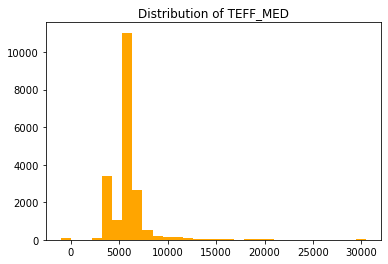

MSE: 4007085.29


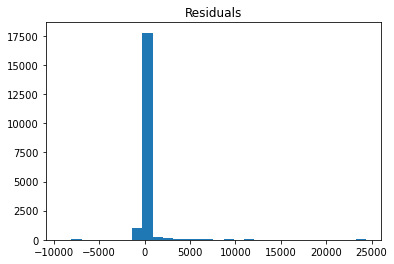

In [5]:
results = model.predict(df_badt.drop(['mangaid', 'teff', 'teff_ext'], axis=1))

target = df_badt['teff_ext']
plt.hist(target, bins=30, color='orange')
plt.title('Distribution of TEFF_MED')
plt.show()

mse = mean_squared_error(target, results)
print('MSE: %.2f' % mse)

residuals = np.array(target).astype('float') - results
plt.title('Residuals')
plt.hist(residuals, bins=30)
plt.show()

This result is pretty bad, when compared to our previous test MSE. Looking at the distribution of TEFF_MED we can see it contains values that are outside of the range seen by our fitting procedure! There is no way our model can handle these properly, and I think it would be valid in this case to have it respond with an "uknownn" result.

In [6]:
goodt = sl.get_goodt()
max_seen = goodt['INPUT_TEFF'].max()
min_seen = goodt['INPUT_TEFF'].min()
print('Model range: (%.1fK - %.1fK)' %(min_seen, max_seen))

badt_lim = sl.get_badt_lim()
df_badt_lim = sl.fits_to_pd(badt_lim)

print('Stars evaluated only by external algorithm, within our model\'s range: %d' % len(df_badt))
print('Stars outside of range: %d' % (len(df_badt)-len(df_badt_lim)))


Model range: (2970.2K - 8975.9K)
Stars evaluated only by external algorithm, within our model's range: 19715
Stars outside of range: 938


Let's drop the 824 out-of-range stars from the evaluation dataset, and retry.

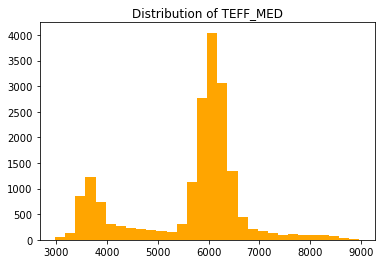

MSE: 33418.23


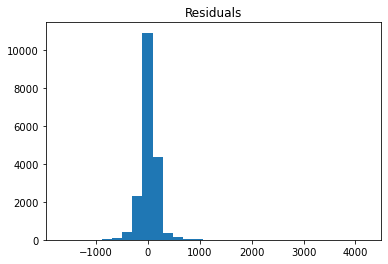

In [8]:

results_ext = model.predict(df_badt_lim.drop(['mangaid', 'teff', 'teff_ext'], axis=1))

target_ext = df_badt_lim['teff_ext']
plt.hist(target_ext, bins=30, color='orange')
plt.title('Distribution of TEFF_MED')
plt.show()

mse = mean_squared_error(target_ext, results_ext)
print('MSE: %.2f' % mse)

residuals = np.array(target_ext).astype('float') - results_ext
plt.title('Residuals')
plt.hist(residuals, bins=30)
plt.show()


This results in a lower MSE. We have to note thought this isn't an expression of improved absolute performance of our model. We are calculating MSE against external models, not true values, and these external modesl are possibly using similar modeling techniques as we are.

All we can conclude is our model has a comparable performance to these external models.